Multivariate LSTM

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

Index(['Abcdin', 'Falabella', 'Lider', 'Paris', 'Ripley', 'claro', 'entel',
       'movistar', 'wom'],
      dtype='object')


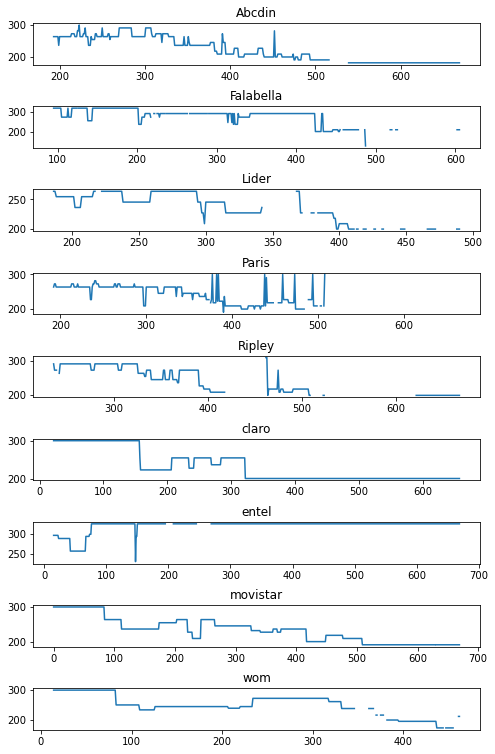

In [14]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
#print(df_wide)
print(df_wide.columns)
i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(wspace=0.4,
                    hspace=1)
plt.show()

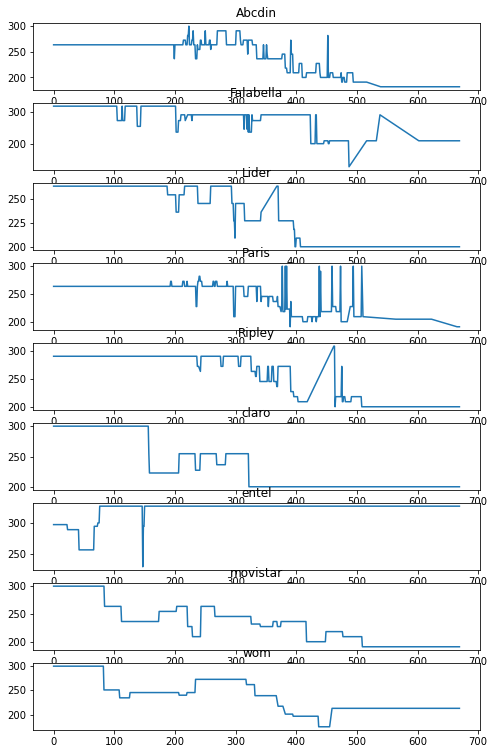

In [15]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [16]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

(670, 9)
(670, 10)


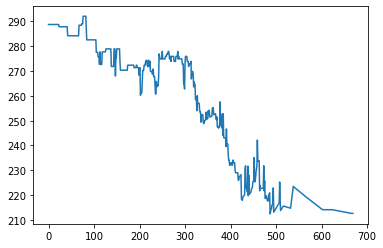

In [17]:
from numpy import hstack
import math
i=0
raw_seq = []
for company in df_wide.columns:
    raw_seq.append(df_wide[company].values)
    raw_seq[i] = raw_seq[i].reshape((len(raw_seq[i]), 1))
    i+=1

dataset = hstack(raw_seq)
print(dataset.shape)

buyers = "minimum"
buyers = "maximum"
buyers = "average"

if buyers == "minimum":
    minimum = [ [min(dataset[i])] for i in range(len(df_wide[company].values))]
elif buyers == "maximum":
    minimum = [ [max(dataset[i])] for i in range(len(df_wide[company].values))]
else:
    minimum = [ [sum(dataset[i])/len(dataset[i])] for i in range(len(df_wide[company].values))]

dataset = np.append(dataset, minimum, axis=1)
print(dataset.shape)
plt.plot(minimum)
plt.show()

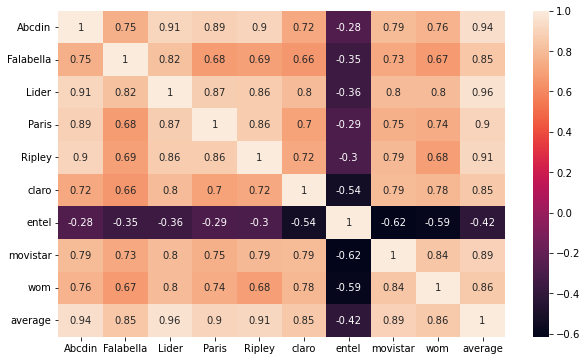

In [18]:
import seaborn as sns

df_wide.insert(i,str(buyers),[item for sublist in minimum for item in sublist])
plt.figure(figsize=(10, 6))
sns.heatmap(df_wide.corr(),annot=True)
plt.savefig("multi_heatmap_"+buyers+".png")

In [ ]:
n_steps = 3
X, y = split_sequences(dataset, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
X_train = X[:value]
y_train = y[:value]
X_test = X[value:]
y_test = y[value:]
print(X_train.shape)
print(y_train.shape)

Multivariate LSTM

In [ ]:
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False)
#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.show()

In [ ]:
yhat = model.predict(X_test)

mse = mean_squared_error(y_test, yhat)
print('Test MSE: %.3f' % mse)

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.xlabel("days")
plt.legend()
plt.show()


In [ ]:
import math
from keras.callbacks import EarlyStopping

percent_train = 0.7
n_features = 1
dic={}
for n_steps in range(1,32):
    X, y = split_sequences(dataset, n_steps)
    value = int(len(X)*percent_train)
    X_train = X[:value]
    y_train = y[:value]
    n_features = X.shape[2]
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    callback = EarlyStopping(monitor='loss', patience=10)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=72, verbose=1, shuffle=False,callbacks=[callback])
    
    yhat = model.predict(X_train)
    mse = mean_squared_error(y_train, yhat)
    dic[n_steps] = mse

In [ ]:
n_steps_best = min(dic, key=dic.get)
X, y = split_sequences(dataset, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
X_train = X[:value]
y_train = y[:value]
X_test = X[value:]
y_test = y[value:]
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')   
callback = EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train, y_train, epochs=10000, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False,callbacks=[callback])

In [ ]:
import statistics
print(buyers,": ",n_steps_best," days")
yhat = model.predict(X_train)
yhat = [item for sublist in yhat for item in sublist]
yhat_train = yhat
print("train")
print("MAE  : ",sum(yhat - y_train)/len(y_train))
#MSE
print("MSE  : ",sum((yhat - y_train)**2)/len(y_train))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_train)**2)/len(y_train))/(statistics.mean(y_train)) )
print("test")
#para o teste
yhat = model.predict(X_test)
yhat = [item for sublist in yhat for item in sublist]
#MAE
print("MAE  : ",sum(yhat - y_test)/len(y_test))
#MSE
print("MSE  : ",sum((yhat - y_test)**2)/len(y_test))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_test)**2)/len(y_test))/(statistics.mean(y_test)) )

plt.plot(dic.keys(),dic.values())
plt.ylabel("MSE")
plt.xlabel("lag days")
plt.savefig("lstm_multi_lag_"+buyers+".png")
plt.show()

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.savefig("lstm_multi_loss_"+buyers+".png")
plt.show()

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.legend()
plt.savefig("lstm_multi_test_"+buyers+".png")
plt.show()

yhat = model.predict(X)
yhat = [item for sublist in yhat for item in sublist]
print("all")
#MAE
print("MAE  : ",sum(yhat - y)/len(y))
#MSE
print("MSE  : ",sum((yhat - y)**2)/len(y))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y)**2)/len(y))/(statistics.mean(y)) )
plt.figure()
plt.plot(y,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.legend()
plt.savefig("lstm_multi_test_all_"+buyers+".png")
plt.show()